# Datasets

In [69]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download rasvanjaya21/inria-holidays-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 351M/352M [00:05<00:00, 78.0MB/s]
100% 352M/352M [00:05<00:00, 72.8MB/s]


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download theaayushbajaj/cbir-dataset

In [ ]:
!unzip cbir-dataset.zip

In [ ]:
!unzip inria-holidays-dataset.zip -d inriadata

In [41]:
image_paths_cbir = os.listdir('./dataset')

In [ ]:
import cv2
import matplotlib.pyplot as plt
im  = cv2.imread("./dataset/"+image_paths_cbir[11])
plt.imshow(im)

In [8]:
dl_descriptors = {}

In [41]:
hog_descriptors  = {}

In [ ]:
sift_descriptors ={}

In [88]:
from sklearn.metrics.pairwise import cosine_similarity

In [100]:
import numpy as np
def find_similar_images(dictionary,query_image_path,dir_path = './dataset',mode = "cosine"):
  similarity_scores = []
  query_features = dictionary[dir_path+'/'+query_image_path]
  for key in dictionary:
    similarity = 0
    if(mode=="cosine"):
      similarity  = cosine_similarity([query_features], [dictionary[key]])[0][0]
    elif(mode =="euclidean"):
      similarity = np.linalg.norm(np.array(query_features)-np.array(dictionary[key]))
    similarity_scores.append((key,similarity))
  reverse = False
  if(mode=="cosine"):
    reverse = True
  similarity_scores.sort(key=lambda x: x[1], reverse=reverse)
  fig,ax= plt.subplots(nrows = 1,ncols = 5,figsize = (8,8))
  ax[0].imshow(np.array(Image.open("./dataset/"+query_image_path).resize((224,224))))
  ax[0].set_title("query_image")
  for i in range(1,5):
    print(i,similarity_scores[i][1])
    ax[i].imshow(np.array(Image.open(similarity_scores[i][0]).resize((224,224))))



0 1.0000002
1 0.85052407
2 0.8487505
3 0.8444205
4 0.8422201


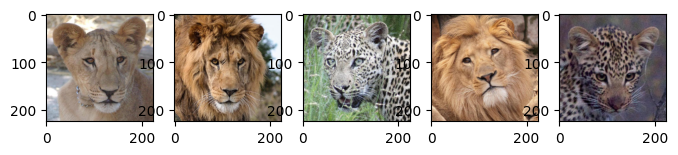

In [63]:
find_similar_images(hog_descriptors,image_paths_cbir[75])

In [22]:
# import pickle

# with open('saved_dictionary.pkl', 'wb') as f:
#     pickle.dump(dl_dict, f)



In [3]:
import pickle
with open('saved_dictionary.pkl', 'rb') as f:
    dl_descriptors = pickle.load(f)

In [14]:
import numpy as np
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import os
from tqdm.auto import tqdm

model = resnet18(pretrained=True)
model.eval()


preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def extract_features(img_path):
    img = Image.open(img_path)
    img_tensor = preprocess(img)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # Add batch dimension
    with torch.no_grad():
        features = model(img_tensor)
    return features.numpy().flatten()

# Function to perform image retrieval
def image_retrieval(query_image_path, database_folder, top_k=5):
    query_features= []
    if(query_image_path in dl_descriptors):
      query_features = dl_descriptors[query_image_path]
    else:
      query_features = extract_features(query_image_path)


    similarity_scores = []

    for filename in tqdm(os.listdir(database_folder)):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            if(database_folder+"/"+filename in dl_descriptors):
              similarity = cosine_similarity([query_features], [dl_descriptors[database_folder+"/"+filename]])[0][0]
              similarity_scores.append((database_folder+"/"+filename, similarity))
              continue
            img_path = os.path.join(database_folder, filename)
            features = extract_features(img_path)
            dl_descriptors[database_folder+"/"+filename] = features
            similarity = cosine_similarity([query_features], [features])[0][0]
            similarity_scores.append((img_path, similarity))


    similarity_scores.sort(key=lambda x: x[1], reverse=True)
    return similarity_scores



# Example usage
query_image_path = './dataset/'+image_paths_cbir[249]
database_folder = './dataset'
similarity_scores = image_retrieval(query_image_path, database_folder)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/4738 [00:00<?, ?it/s]

In [ ]:
im = Image.open("./dataset/"+image_paths_cbir[249])
im


1 0.8832773
2 0.88229954
3 0.8814642
4 0.88055426


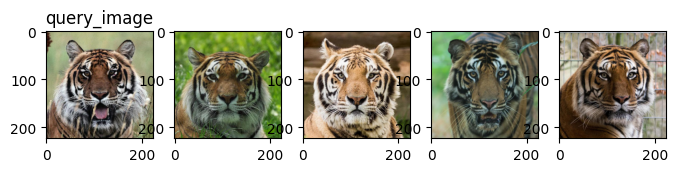

In [93]:
find_similar_images(dl_descriptors,image_paths_cbir[249])

1 0.92174876
2 0.9204933
3 0.91060716
4 0.90717995


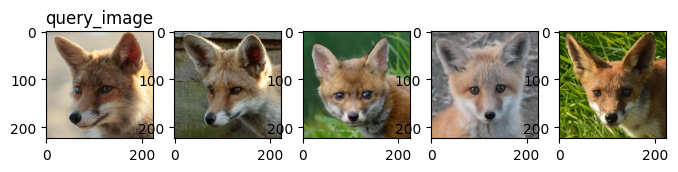

In [91]:
find_similar_images(dl_descriptors,image_paths_cbir[789])

1 0.928054
2 0.9240724
3 0.92227095
4 0.9173472


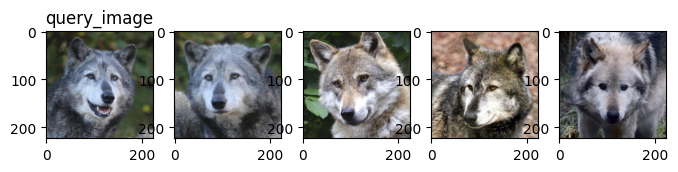

In [92]:
find_similar_images(dl_descriptors,image_paths_cbir[3000])

1 0.92463577
2 0.9209834
3 0.91680586
4 0.9129645


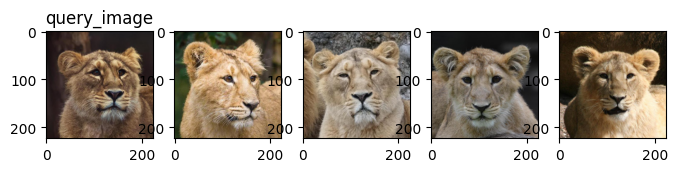

In [94]:
find_similar_images(dl_descriptors,image_paths_cbir[300])

1 0.9290381
2 0.9288094
3 0.9287894
4 0.9262583


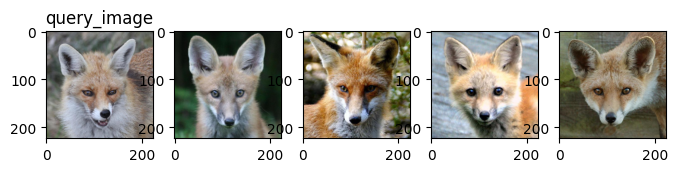

In [95]:
find_similar_images(dl_descriptors,image_paths_cbir[3900])

In [ ]:
sift_descriptors = {}

In [118]:
import cv2
def sift_euclidean(img1, img2,img1path=None,img2path=None):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    bf = cv2.BFMatcher()
    matches = bf.match(des1, des2)
    return sum(c.distance for c in matches)


In [119]:
img1 = np.array(Image.open("./dataset/"+image_paths_cbir[249]).resize((64,64)))
temp  =[]
for img2path in tqdm(image_paths_cbir):
  img2 = np.array(Image.open("./dataset/"+img2path).resize((64,64)))
  dist = sift_euclidean(img1,img2)
  temp.append((img2path,dist))

  0%|          | 0/4738 [00:00<?, ?it/s]

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

In [42]:
feature_vectors = list(dl_descriptors.values())

100%|██████████| 14/14 [00:58<00:00,  4.20s/it]


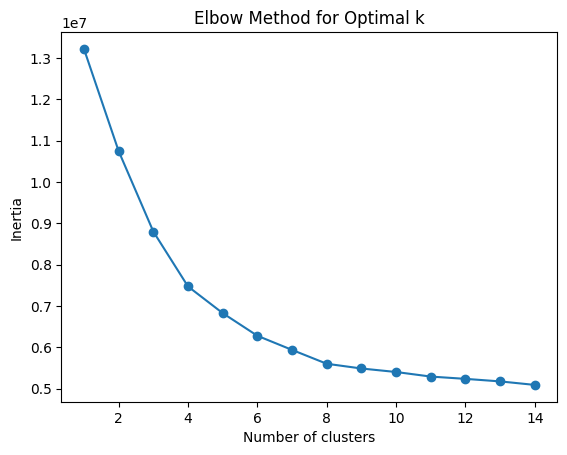

In [45]:
inertia = []
max_clusters = 14
for k in tqdm(range(1, max_clusters + 1)):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init = 10)
    kmeans.fit(feature_vectors)
    inertia.append(kmeans.inertia_)


plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
silhouette_scores = []
max_clusters = 14
for k in tqdm(range(2, max_clusters + 1)):
    kmeans = KMeans(n_clusters=k, random_state=42,n_init = 10)
    kmeans.fit(feature_vectors)
    silhouette_avg = silhouette_score(feature_vectors, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)


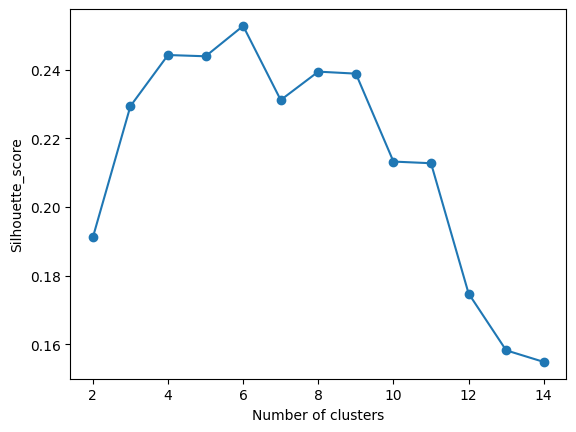

In [49]:
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette_score')
plt.show()

In [ ]:
image_dir = "./dataset/test"
image_paths = os.listdir(image_dir)

In [71]:
# import the necessary packages
import numpy as np
import cv2
class FeatureDescriptor:
	def __init__(self, bins):
		self.bins = bins
	def describe(self, image):
		image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
		features = []
		(h, w) = image.shape[:2]
		(cX, cY) = (int(w * 0.5), int(h * 0.5))
		segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h),
			(0, cX, cY, h)]
		(axesX, axesY) = (int(w * 0.75) // 2, int(h * 0.75) // 2)
		ellipMask = np.zeros(image.shape[:2], dtype = "uint8")
		cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)
		for (startX, endX, startY, endY) in segments:
			cornerMask = np.zeros(image.shape[:2], dtype = "uint8")
			cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
			cornerMask = cv2.subtract(cornerMask, ellipMask)
			hist = self.histogram(image, cornerMask)
			features.extend(hist)
		hist = self.histogram(image, ellipMask)
		features.extend(hist)
		return features
	def histogram(self, image, mask):
		hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins,
			[0, 180, 0, 256, 0, 256])

		hist = cv2.normalize(hist, hist).flatten()
		return hist



In [97]:
fd = FeatureDescriptor((8,12,3))


In [96]:
custom_features = {}

In [71]:
print(len(fd.describe(np.array(im))))

1440


In [98]:
for image_path in tqdm(image_paths_cbir):
  im = Image.open("./dataset/"+image_path)
  custom_features["./dataset/"+image_path]= (fd.describe(np.array(im)))


  0%|          | 0/4738 [00:00<?, ?it/s]

1 1.879127
2 1.8986268
3 1.9042317
4 1.990097


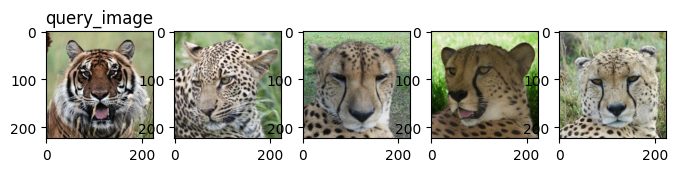

In [101]:
find_similar_images(custom_features,image_paths_cbir[249],mode="euclidean")

1 1.7366089
2 1.866498
3 1.8937515
4 1.9005061


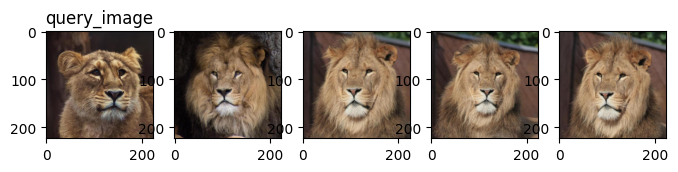

In [103]:
find_similar_images(custom_features,image_paths_cbir[300],mode="euclidean")

0 1.0000002
1 0.698419
2 0.6516185
3 0.64137065
4 0.6388077


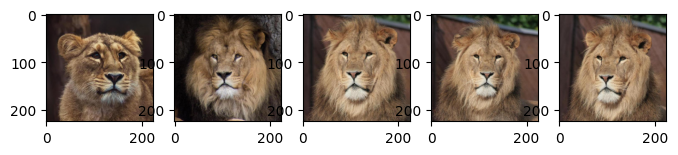

In [76]:
find_similar_images(custom_features,image_paths_cbir[300],mode="cosine")

1 0.80995375
2 0.74824756
3 0.7387732
4 0.7285975


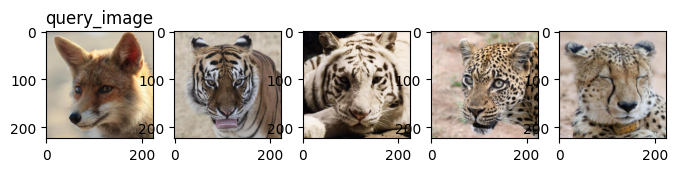

In [104]:
find_similar_images(custom_features,image_paths_cbir[789])

1 0.74495137
2 0.56758654
3 0.5010002
4 0.47367576


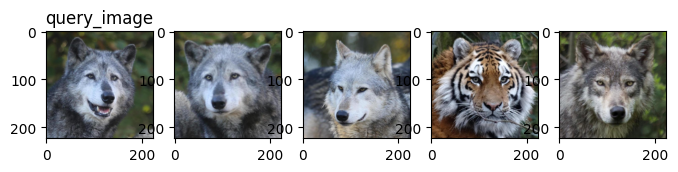

In [105]:
find_similar_images(custom_features,image_paths_cbir[3000])

1 0.7046661
2 0.701721
3 0.6968966
4 0.6615882


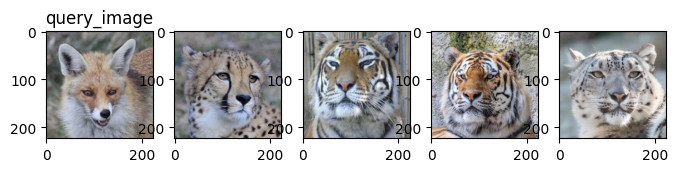

In [106]:
find_similar_images(custom_features,image_paths_cbir[3900])

In [72]:
inria_dirs = os.listdir("./inriadata")
image_paths_inria = []
for dir in inria_dirs:
  image_paths_inria.extend(["./inriadata/"+dir+'/'+im for im in os.listdir("./inriadata/"+dir)])

In [73]:
FD = FeatureDescriptor((8,12,3))
inria_dic = {}

In [79]:
import matplotlib.pyplot as plt
def find_similar_inria(query_image_path):
  feats_src = inria_dic[query_image_path]
  results = []
  for idx,image in tqdm(enumerate(image_paths_inria)):
    feats_here = inria_dic[image]
    dist = np.linalg.norm(np.array(feats_src)-np.array(feats_here))
    results.append((image,dist))
  results.sort(key=lambda x: x[1])
  fig,ax= plt.subplots(nrows = 1,ncols = 5,figsize = (8,8))
  for i in range(5):
    ax[i].imshow(np.array(Image.open(results[i][0]).resize((224,224))))

0it [00:00, ?it/s]

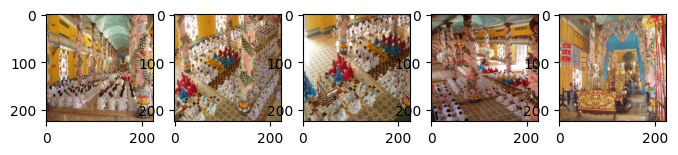

In [80]:
find_similar_inria(image_paths_inria[60])

0it [00:00, ?it/s]

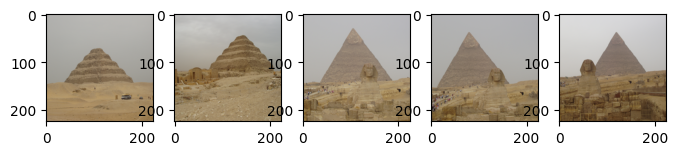

In [81]:
find_similar_inria(image_paths_inria[100])

0it [00:00, ?it/s]

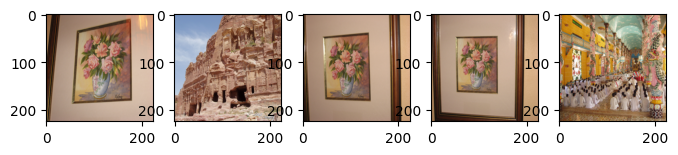

In [83]:
find_similar_inria(image_paths_inria[120])

0it [00:00, ?it/s]

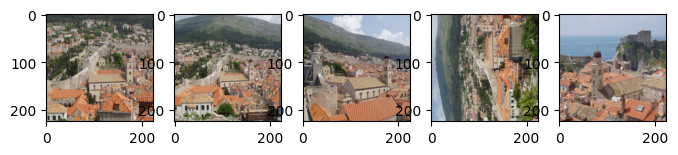

In [84]:
find_similar_inria(image_paths_inria[89])

0it [00:00, ?it/s]

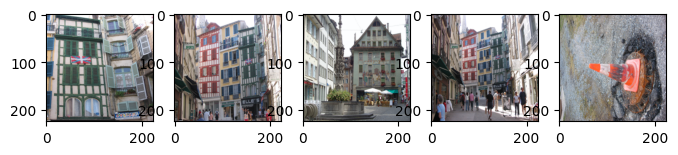

In [85]:
find_similar_inria(image_paths_inria[12])

#AutoEncoder

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torchvision
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, SequentialSampler, BatchSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import itertools

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class Encoder(nn.Module):

    def __init__(self, out_dim):
        super().__init__()

        self.layers = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=5, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(64, 128, kernel_size=5, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(128),

        nn.Conv2d(128, 256, kernel_size=5, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(256, 512, kernel_size=5, stride=2),
        nn.ReLU(),
        # nn.BatchNorm2d(512),
        nn.Flatten(),

        nn.Linear(512, 1000),
        nn.ReLU(),

        nn.Linear(1000, out_dim)
        )

    def forward(self, input: torch.Tensor):
        out = self.layers(input)

        return out

class Decoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.layers = nn.Sequential(
        nn.Linear(input_dim, 1000),
        nn.ReLU(),
        nn.Linear(1000, 512),
        torch.nn.Unflatten(-1, (512, 1, 1)),

        nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2),
        nn.ReLU(),
        nn.BatchNorm2d(128),

        nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, output_padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, output_padding=1),
        nn.Sigmoid()
        )

    def forward(self, input: torch.Tensor):
        out = self.layers(input)
        return out

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import os
from tqdm.auto import tqdm
from PIL import Image
# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_list[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Hyperparameters
batch_size = 64
num_epochs = 10
learning_rate = 0.001

# Dataset and DataLoader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = CustomDataset(root_dir='./dataset', transform=transform)
train_size = int(0.8 * len(dataset))
train_data, _ = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


encoder = Encoder(out_dim=1000).to(device)
decoder = Decoder(input_dim=1000).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# Training loop
for epoch in tqdm(range(num_epochs)):
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        input_img = data.to(device)
        encoded = encoder(input_img)
        reconstructed = decoder(encoded)
        loss = criterion(reconstructed, input_img)
        loss.backward()
        optimizer.step()

        if (batch_idx ) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, batch_idx + 1, len(train_loader), loss.item()))



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [1/60], Loss: 0.6387
Epoch [1/10], Step [11/60], Loss: 0.4056
Epoch [1/10], Step [21/60], Loss: 0.3461
Epoch [1/10], Step [31/60], Loss: 0.2695
Epoch [1/10], Step [41/60], Loss: 0.2781
Epoch [1/10], Step [51/60], Loss: 0.2607
Epoch [2/10], Step [1/60], Loss: 0.2467
Epoch [2/10], Step [11/60], Loss: 0.2440
Epoch [2/10], Step [21/60], Loss: 0.2513
Epoch [2/10], Step [31/60], Loss: 0.2277
Epoch [2/10], Step [41/60], Loss: 0.2381
Epoch [2/10], Step [51/60], Loss: 0.2283
Epoch [3/10], Step [1/60], Loss: 0.2254
Epoch [3/10], Step [11/60], Loss: 0.2269
Epoch [3/10], Step [21/60], Loss: 0.2211
Epoch [3/10], Step [31/60], Loss: 0.2237
Epoch [3/10], Step [41/60], Loss: 0.2229
Epoch [3/10], Step [51/60], Loss: 0.2018
Epoch [4/10], Step [1/60], Loss: 0.2171
Epoch [4/10], Step [11/60], Loss: 0.2129
Epoch [4/10], Step [21/60], Loss: 0.2210
Epoch [4/10], Step [31/60], Loss: 0.2245
Epoch [4/10], Step [41/60], Loss: 0.2149
Epoch [4/10], Step [51/60], Loss: 0.2160
Epoch [5/10], Step [

In [ ]:
transform()

<module 'torchvision.transforms' from '/usr/local/lib/python3.10/dist-packages/torchvision/transforms/__init__.py'>

In [ ]:

# Function to extract features from an image using ResNet model
def extract_features(model,img_path):
    img = Image.open(img_path)
    img_tensor = transform(img)
    img_tensor = torch.unsqueeze(img_tensor, 0)  # Add batch dimension
    with torch.no_grad():
        img_tensor = img_tensor.to(device)
        features = model(img_tensor)
    return features.cpu().numpy().flatten()


In [ ]:
ae_descriptors = {}
image_paths_cbir = os.listdir("./dataset")
for image_path in image_paths_cbir:
  feature_vector = extract_features(encoder,"./dataset/"+image_path)
  ae_descriptors["./dataset/"+image_path] = feature_vector


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def find_similar_images(dictionary,query_image_path,dir_path = './dataset'):
  similarity_scores = []
  query_features = dictionary[dir_path+'/'+query_image_path]
  for key in dictionary:
    # similarity  = cosine_similarity([query_features], [dictionary[key]])[0][0]
    similarity = np.linalg.norm(query_features-dictionary[key])
    similarity_scores.append((key,similarity))
  similarity_scores.sort(key=lambda x: x[1])
  fig,ax= plt.subplots(nrows = 1,ncols = 5,figsize = (8,8))
  for i in range(5):
    print(i,similarity_scores[i][1])
    ax[i].imshow(np.array(Image.open(similarity_scores[i][0]).resize((224,224))))

0 0.0
1 5.830125
2 7.187833
3 7.597744
4 7.7826753


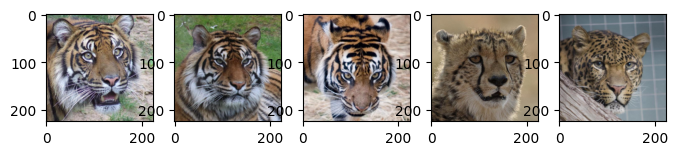

In [ ]:
find_similar_images(ae_descriptors,image_paths_cbir[249])

0 0.0
1 5.9628677
2 6.866894
3 7.5803604
4 8.061928


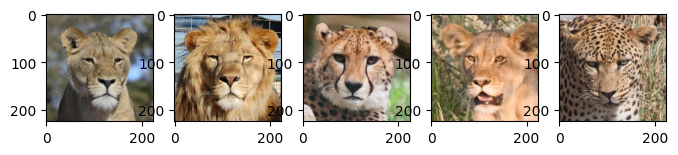

In [ ]:
find_similar_images(ae_descriptors,image_paths_cbir[789])

0 0.0
1 8.402341
2 8.444121
3 8.945556
4 10.959729


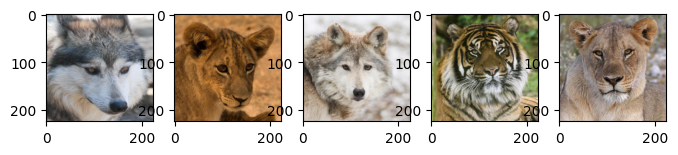

In [ ]:
find_similar_images(ae_descriptors,image_paths_cbir[3000])

0 0.0
1 22.769857
2 23.194231
3 24.371517
4 32.11465


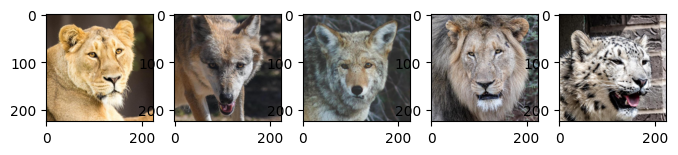

In [ ]:
find_similar_images(ae_descriptors,image_paths_cbir[300])

0 0.0
1 10.549129
2 10.992509
3 11.859101
4 12.24085


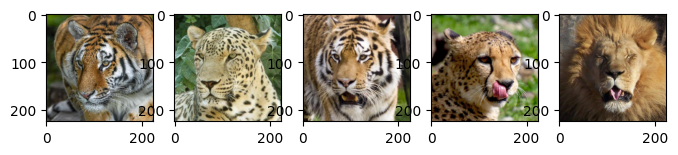

In [ ]:
find_similar_images(ae_descriptors,image_paths_cbir[3900])